In [1]:
import json
import numpy as np
import sys
import os
import torch
from PIL import Image
import cv2

/home/marcelln/miniconda3/envs/datawran/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append(os.path.join(sys.path[0], '../../msc_visualdata_wrangling/processing/'))
from decode import spherical2cartesian, decode, transform_camsph2bb, transform_cambb2sph, add_bb_frmcamsph

In [3]:
sys.path.append(os.path.join(sys.path[0], '../../msc_detector_evaluation/tooling/'))
from mymodels import pretrained_yolov5s

## Read dataset

In [4]:
sample_no = 0

In [5]:
name_step = '../test_data/trackkick_'+str(sample_no)+'.json'
with open(name_step, 'r') as input_file:
    step_dict = json.load(input_file)

In [6]:
name_img = '../test_data/outimg_WITS-FC2-'+str(sample_no)+'.json'
with open(name_img, 'r') as input_file:
    img_dict = json.load(input_file)

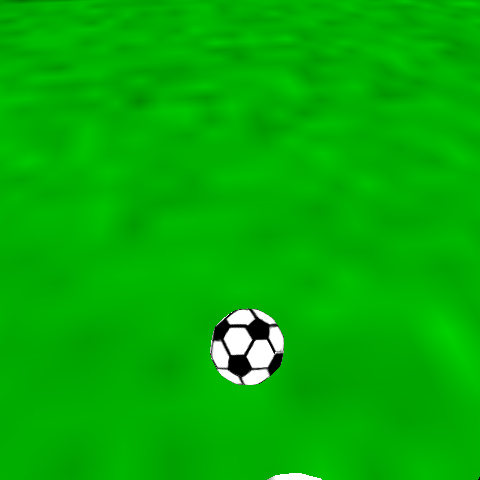

In [7]:
test_img = decode(img_dict['img'], img_dict['h_img'], img_dict['w_img'])
test_img = Image.fromarray(test_img)
test_img

## Convert to bb to spherical

#### Extract ground truths

In [8]:
gt_sph = img_dict['ball_locate']
gt_bb = transform_camsph2bb(np.asarray(test_img), gt_sph)

#### Create prediction

In [9]:
model = pretrained_yolov5s(None, None)

Using cache found in /home/marcelln/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-18 Python-3.10.10 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)



requirements: /home/marcelln/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [10]:
detections = model.forward(test_img)[0]
pred_boxes = detections[0:4]
pred_bb = (pred_boxes[3]+pred_boxes[1])/2, (pred_boxes[0]+pred_boxes[2])/2, ((pred_boxes[2]-pred_boxes[0]+pred_boxes[3]-pred_boxes[1])/2)/2
pred_sph = transform_cambb2sph(np.asarray(test_img), pred_bb)

## Inspect results

In [11]:
print("Gt spherical:", gt_sph)
print("Pred spherical:", pred_sph)
print("")
print("Gt bb:", gt_bb)
print("Pred bb:", pred_bb)

Gt spherical: [0.55, -0.81, -12.09]
Pred spherical: (0.5813031610718894, -0.8912878954877109, -12.445474248484937)

Gt bb: (344.4904543003391, 246.16582262090333, 40.92398635070995)
Pred bb: (346.921630859375, 246.76197814941406, 38.444252014160156)


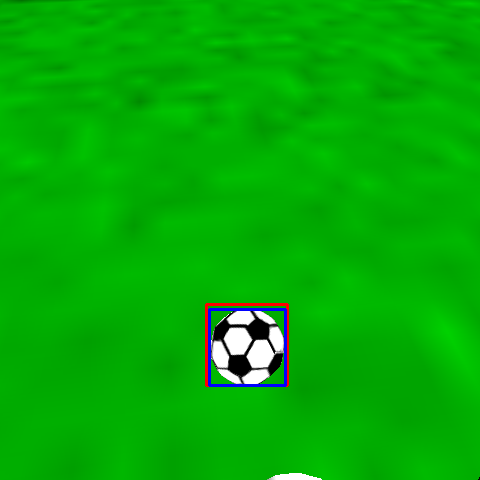

In [12]:
test_img = decode(img_dict['img'], img_dict['h_img'], img_dict['w_img'])
add_bb_frmcamsph(test_img, gt_sph, color = (255,0,0))
add_bb_frmcamsph(test_img, pred_sph, color = (0,0,255)) 
test_img = Image.fromarray(test_img)
test_img

## Convert to spherical to cartesian coords

In [13]:
if img_dict['ball_sighted'] == 1:
    coords_spher_cam = np.array(img_dict['ball_locate'])
    coords_cart_cam = spherical2cartesian(*coords_spher_cam)  # Unpack iterable using *
    coords_local = (np.array(step_dict['mat_cam2local'])@np.append(coords_cart_cam, 1))[:-1]
    coords_global = (np.array(step_dict['mat_l2g'])@np.append(coords_local, 1))[:-1]
    
    pred_cart_cam = spherical2cartesian(*pred_sph)  # Unpack iterable using *
    pred_local = (np.array(step_dict['mat_cam2local'])@np.append(pred_cart_cam, 1))[:-1]
    pred_global = (np.array(step_dict['mat_l2g'])@np.append(pred_local, 1))[:-1]

    full_mat = np.array(step_dict['mat_l2g'])@np.array(step_dict['mat_cam2local'])
    full_global = (full_mat@np.append(coords_cart_cam, 1))[:-1]

In [14]:
print("Gt local:", step_dict['see_ball_local'])
print("Transform to local:", coords_local)
print("Pred local:", pred_local)
print("")
print("Gt global:", step_dict['see_ball_global'])
print("Transform to global:", coords_global)
print("Pred global:", pred_global)
print("")
print("Full transform:", full_global)

Gt local: [0.289915, -0.0832104, -0.308692]
Transform to local: [    0.28991    -0.08321    -0.30869]
Pred local: [    0.30307   -0.087898    -0.33694]

Gt global: [7.00767, 1.06134, 0.0477784]
Transform to global: [     7.0077      1.0613    0.047778]
Pred global: [     7.0213      1.0582    0.019535]

Full transform: [     7.0077      1.0613    0.047778]
